## Analysis of Congressperson Public Perception using Twitter

In [1]:
## Code based on: http://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/

In [2]:
%%writefile publicperception.py
from __future__ import print_function
import re
import tweepy
import pandas as pd
from tweepy import OAuthHandler
from textblob import TextBlob
from collections import defaultdict
import string 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import argparse
import csv

from os import path
from IPython.display import Image
from wordcloud import WordCloud

import matplotlib.pyplot as plt

# #writing to CSV file
# with open('findata/twitter_file.csv','a') as f1:
#     writer=csv.writer(f1, delimiter='\t',lineterminator='\n',)
    
    

#argparse
parser = argparse.ArgumentParser(description='Prepping for command line entry')
parser.add_argument('name', type=str)
args = parser.parse_args()
REP_ID = args.name


#Converting rep_id to name for twitter query

#read in CSV file
df_t = pd.read_csv('findata/fincampaign_twitter.csv')

#taking from capitalized to sentence case
df_t['name'] = df_t['name'].apply(lambda x : x.title())

#replacing titles... there most certainly is a better way to do this
df_t['name'] = df_t['name'].apply(lambda x: x.replace('Mr. ',''))
df_t['name'] = df_t['name'].apply(lambda x: x.replace('Dr. ',''))
df_t['name'] = df_t['name'].apply(lambda x: x.replace('Mrs. ',''))
df_t['name'] = df_t['name'].apply(lambda x: x.replace('Ms. ',''))

#replacing middle names... 
df_t['name'] = df_t['name'].apply(lambda x : x.replace(". "," "))
df_t['name'] = df_t['name'].apply(lambda x: re.sub(r'(?:^| )\w(?:$| )', ' ', x).strip())

#converting query ID to cleaned-up name!
QUERY_NAME = df_t.ix[(df_t == REP_ID).idxmax(axis=0)[0]]['name']


#Now for the Twitter stuff

class TwitterClient(object):
    '''
    Generic Twitter Class for sentiment analysis.
    '''
    def __init__(self):
        '''
        Class constructor or initialization method.
        '''
        # keys and tokens from the Twitter Dev Console
        consumer_key = '7UWH0Z6a97w96HG7QQOKC0fb4'
        consumer_secret = 'BZHDC01c5elCDlxKZvoU7UaRKqKCO1ptEau7UyCEIkve2j5xyo'
        access_token = '929794801716813826-bB4PUniIhbsMArpBbSeB7kZOtOMQW1q'
        access_token_secret = 'rWqdoPC1kILjejG0jSkwrT6YgVjU9GpFu0WdTGmoMhwDE'

        # attempt authentication
        try:
            # create OAuthHandler object
            self.auth = OAuthHandler(consumer_key, consumer_secret)
            # set access token and secret
            self.auth.set_access_token(access_token, access_token_secret)
            # create tweepy API object to fetch tweets
            self.api = tweepy.API(self.auth)
        except:
            print("Error: Authentication Failed")

    def clean_tweet(self, tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    def get_tweet_sentiment(self, tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
        # create TextBlob object of passed tweet text
        analysis = TextBlob(self.clean_tweet(tweet))
        # set sentiment
        if analysis.sentiment.polarity > 0:
            return 'positive'
        elif analysis.sentiment.polarity == 0:
            return 'neutral'
        else:
            return 'negative'

    def get_tweets(self, query, count = 10):
        '''
        Main function to fetch tweets and parse them.
        '''
        # empty list to store parsed tweets
        tweets = []

        try:
            # call twitter api to fetch tweets
            fetched_tweets = self.api.search(q = query, count = count)

            # parsing tweets one by one
            for tweet in fetched_tweets:
                # empty dictionary to store required params of a tweet
                parsed_tweet = {}

                # saving text of tweet
                parsed_tweet['text'] = tweet.text
                # saving sentiment of tweet
                parsed_tweet['sentiment'] = self.get_tweet_sentiment(tweet.text)

                # appending parsed tweet to tweets list
                if tweet.retweet_count > 0:
                    # if tweet has retweets, ensure that it is appended only once
                    if parsed_tweet not in tweets:
                        tweets.append(parsed_tweet)
                else:
                    tweets.append(parsed_tweet)

            # return parsed tweets
            return tweets

        except tweepy.TweepError as e:
            # print error (if any)
            print("Error : " + str(e))

def main():
    # creating object of TwitterClient Class
    api = TwitterClient()
    # calling function to get tweets
    tweets = api.get_tweets(query = QUERY_NAME, count = 200)

    print ("Public Perception of ", QUERY_NAME, "\n")
    #what is our total amount of tweets
    print("Total tweets: {}".format(100*len(tweets)))

    # picking positive tweets from tweets
    ptweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive']
    # percentage of positive tweets
    print("Positive tweets percentage: {} %".format(100*len(ptweets)/len(tweets)))
    # picking negative tweets from tweets
    ntweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']
    # percentage of negative tweets
    print("Negative tweets percentage: {} %".format(100*len(ntweets)/len(tweets)))
    # percentage of neutral tweets
    print("Neutral tweets percentage: {} % ".format(100*(len(tweets) - len(ntweets) - len(ptweets))/len(tweets)))

    #cleaning up topics list from https://www.congress.gov/browse/policyarea/115th-congress
    topics_list = [
    'Agriculture and Food [127]', 'Animals [52]','Armed Forces and National Security [664]','Arts, Culture, Religion [33]',
    'Civil Rights and Liberties, Minority Issues [111]',
    'Commerce [155]','Congress [306]','Crime and Law Enforcement [445]','Economics and Public Finance [96]',
    'Education [308]','Emergency Management [103]','Energy [212]',
    'Environmental Protection [195]','Families [44]','Finance and Financial Sector [270]',
    'Foreign Trade and International Finance [55]','Government Operations and Politics [573]',
    'Health [791]','Housing and Community Development [80]','Immigration [222]',
    'International Affairs [475]','Labor and Employment [214]','Law [74]',
    'Native Americans [106]','Public Lands and Natural Resources [439]','Science, Technology, Communications [180]',
    'Social Sciences and History [4]','Social Welfare [97]','Sports and Recreation [44]',
    'Taxation [647]','Transportation and Public Works [249]','Water Resources Development [46]']

    #cleaning up topics
    topics_ = [str(item).split("[")[0] for item in topics_list]

    #Adding some interesting topics
    topics_.insert(0,"Media")
    topics_.insert(0,"News")
    topics_.insert(0,"Trial")
    topics_.insert(0,"Left")
    topics_.insert(0,"Right")
    topics_.insert(0,"Money")
    topics_.insert(0,"America")

    #making dictionary to keep track of the topics being discussed online
    topics_dict = defaultdict(dict)

    stop_words = set(stopwords.words( 'english' ))
    tweets_ = list(tweets)

    list_of_tweets = [w['text'] for w in tweets_]

    #turning list of strings into string
    list_of_tweets = " ".join(list_of_tweets)
    words_in_tweets = [w.encode('utf-8').translate(None, string.punctuation).lower() for w in list_of_tweets.split(" ")]

    #to hold words for wordcloud
    text_list = []

    #take out stopwords
    filtered_sentence = [w for w in words_in_tweets if not w in stop_words]
    for item in topics_:
        topic_string = item.translate(None, string.punctuation).lower()
        for i in filtered_sentence:
            text_list.append(i)
            if i in topic_string:
                if len(i) > 2:
                    try:
                        if topics_dict[item][i]:
                            topics_dict[item][i] += 1  
                        else:
                            topics_dict[item][i] = 1
                    except:
                        topics_dict[item][i] = 1                      

    #joining text_list to string
    text = " ".join(text_list)

    ###Topic Summary

    if not topics_dict:
        print ("\nTopics: Variety")
    else:
        print ("\nTopics: \n")
        i = 1
        for k,v in topics_dict.iteritems():
            print (i," - ", k, ": ", sum(v.values()),"tweet(s).")
            i += 1

    #word cloud portion!
        wordcloud = WordCloud().generate(text)
        wordcloud = WordCloud(max_font_size=40).generate(text)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.savefig('word_cloud.png')
#         #plt.show(block=True);


#         #Writing to CSV file (part 2):
#         row = list((QUERY_NAME, str(100*len(tweets_)),str(100*len(ptweets)),str(100*len(ntweets))))
#         writer.writerow(row)

if __name__ == "__main__":
    # calling main function
    main()

Overwriting publicperception.py


In [3]:
!python -W ignore publicperception.py  "H6NY09137" 

Public Perception of  Jaime Sanders 

Total tweets: 1100
Positive tweets percentage: 27 %
Negative tweets percentage: 9 %
Neutral tweets percentage: 63 % 

Topics: 

1  -  Public Lands and Natural Resources  :  1 tweet(s).
2  -  Animals  :  1 tweet(s).
3  -  Money :  1 tweet(s).
4  -  Water Resources Development  :  1 tweet(s).
5  -  Sports and Recreation  :  3 tweet(s).
6  -  Transportation and Public Works  :  3 tweet(s).


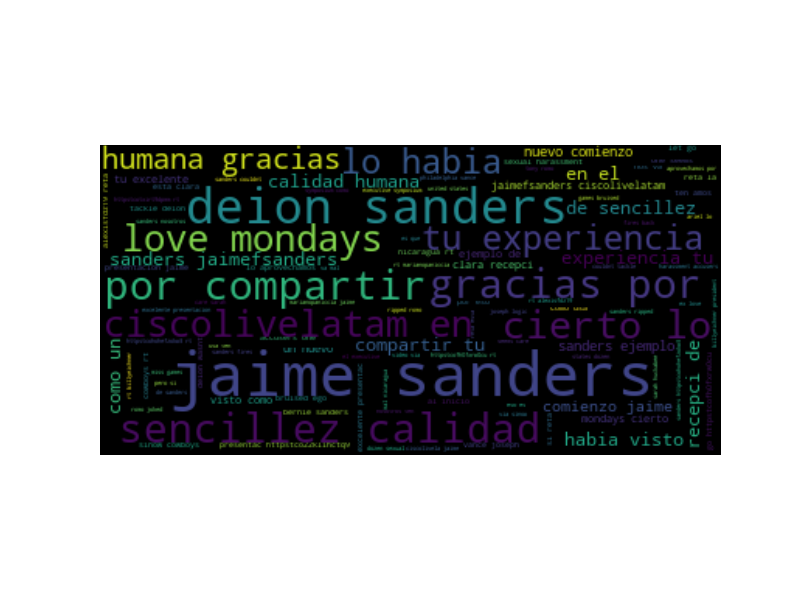

In [4]:
from IPython.display import Image
Image(filename='word_cloud.png')

In [5]:
# ##Trying to build a database.....
# h = pd.read_csv('findata/fincampaign_twitter.csv')
# %timeit
# for id_ in h['id'][100:400]:
#     !python -W ignore publicperception.py {id_}
    
# print "** COMPLETE **"

In [6]:
#!head findata/twitter_file.csv